# 3-D Data Visualization Notebook

The purpose of this notebook is to produce visualizations of the topoclusters/events and display them with tracks

In [2]:
# python
import numpy as np
import time as t

# physics
import uproot as ur
import awkward as ak
import vector as vec
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))
print("Vector version: "+str(vec.__version__))

# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# import k3d

Awkward version: 1.2.2
Uproot version: 4.0.7
Vector version: 0.8.1


#### Branch Info

In [3]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

### Functions

In [12]:
def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def find_index_1D(_values, _unsorted):
    ''' This function is a vectorized helper function to return the 1D locations of elements in a 
    larger unsorted list (i.e. cell geo locations). It does this by repeating/tiling arrays so they
    have equal shape and then simply comparing where the elements are equal and returning a slice
    where the indices match.
    Inputs: 
        _values: the values for which to search for the locations of in _unsorted
        _unsorted: the larger un-sorted list of elements to match
    Returns:
        _locs: locations of _values in _unsorted respectively. '''
    _shape = (len(_values), len(_unsorted))
    _values_2d = np.repeat(_values, repeats=len(_unsorted)).reshape(_shape)
    _unsorted_2d = np.tile(_unsorted, reps=len(_values)).reshape(_shape)
    
    _idx_vec = np.argwhere(np.asarray(_values_2d == _unsorted_2d))
    return _idx_vec[:,1]

def to_xyz(_coords):
    ''' Simple geometric conversion to xyz from eta, phi, rperp (READ: in this order)
    There is an elegant way to generalize this to be flexible for 1d or 2d, for now 2d
    Inputs: np array of shape (N, 3) where columns are [eta, phi, rPerp]
    Outputs: np array of shape (N, 3) where columns are [x,y,z] '''
    _eta = _coords[:,0]
    _phi = _coords[:,1]
    _rperp = _coords[:,2]
    _theta = 2*np.arctan( np.exp(-_eta) )
    
    cell_x = _rperp*np.cos(_phi)
    cell_y = _rperp*np.sin(_phi)
    cell_z = _rperp/np.tan(_theta)
    
    return np.column_stack([cell_x,cell_y,cell_z])

#### Load stuff up

In [5]:
events = '/fast_scratch/atlas_images/v01-45/pipm/'
my_event = ur.open(events+'user.angerami.24559744.OutputStream._000502.root')
my_event.keys()

['EventTree;1', 'CellGeo;1']

In [6]:
event_tree = my_event['EventTree']
geo_tree = my_event['CellGeo']

In [7]:
event_dict = dict_from_event_tree(event_tree, event_branches)

In [8]:
track_dict = dict_from_tree_branches(event_tree, track_branches)

In [9]:
geo_dict = dict_from_tree_branches_np(geo_tree, geo_branches)

#### Load up your favorite event

In [10]:
event = 22

In [72]:
ak_cluster_cell_ID = event_dict['cluster_cell_ID'][event]
cell_geo_ID = geo_dict['cell_geo_ID']

nClust = len(ak_cluster_cell_ID)

clusters = []
for j in range(nClust):
    
    # find cluster size
    _nInClust = len(ak_cluster_cell_ID[j])

    # make empty array of cluster info
    _cluster = np.zeros((_nInClust, 5))
    
    # index matching
    _indices = find_index_1D(ak_cluster_cell_ID[j].to_numpy(), cell_geo_ID)

    _cluster[:,0] = geo_dict["cell_geo_eta"][_indices]
    _cluster[:,1] = geo_dict["cell_geo_phi"][_indices]
    _cluster[:,2] = geo_dict["cell_geo_rPerp"][_indices]
    _cluster[:,3] = event_dict["cluster_cell_E"][event][j].to_numpy()
    _cluster[:,4] = geo_dict["cell_geo_sampling"][_indices]
    
    clusters.append(_cluster)

## Add Tracks
Find roughly where rPerp is for each layer (this varies)

In [64]:
n_tracks = event_dict['nTrack'][event]
print(n_tracks)

1


In [73]:
all_clusters = np.ndarray.copy(clusters[0])
for i in range(1,len(clusters)):
    all_clusters = np.vstack((all_clusters, clusters[i]))

In [79]:
layer_rPerp = []
layer_filter = [1,2,3,12,13,14]

for _layer in layer_filter:
    _mask = all_clusters[:,4] == _layer
    _rPerp_layer = all_clusters[_mask,2]
    layer_rPerp.append(np.mean(_rPerp_layer))
np.array(layer_rPerp)
print(np.round(layer_rPerp,2))

[1540.01 1733.26 1930.01 2450.   3010.   3630.  ]


In [85]:
tracks = np.zeros(12)
i = 0
for _key in track_branches:
    tracks[i] = track_dict[_key][event][0]
    i += 1
tracks = np.reshape(tracks, (6,2))
tracks = np.column_stack((tracks,layer_rPerp))

[[ 6.30000e-01 -2.28000e+00  1.54001e+03]
 [ 6.30000e-01 -2.28000e+00  1.73326e+03]
 [ 6.30000e-01 -2.28000e+00  1.93001e+03]
 [ 6.30000e-01 -2.28000e+00  2.45000e+03]
 [ 6.30000e-01 -2.28000e+00  3.01000e+03]
 [ 6.30000e-01 -2.28000e+00  3.63000e+03]]
[[ 6.26764238e-01 -2.28493071e+00  1.54000503e+03]
 [ 6.26764238e-01 -2.28493500e+00  1.73325577e+03]
 [ 6.26764238e-01 -2.28494120e+00  1.93000602e+03]
 [ 6.26764119e-01 -2.28494883e+00  2.45000002e+03]
 [ 6.26761258e-01 -2.28495741e+00  3.01000013e+03]
 [ 6.26752198e-01 -2.28498340e+00  3.63000005e+03]]


### Data Conversions

In [18]:
cluster_xyz = []
for i in range(len(clusters)):
    _xyz = to_xyz(clusters[i][:,0:3])
    cluster_xyz.append(_xyz)

In [86]:
tracks_xyz = to_xyz(tracks)

## 3-D Visualizations

In [19]:
# keep making this bigger as the events go on
colors = ['blue', 'red', 'gold', 'darkturquoise', 'indigo', 'crimson', 'orange']

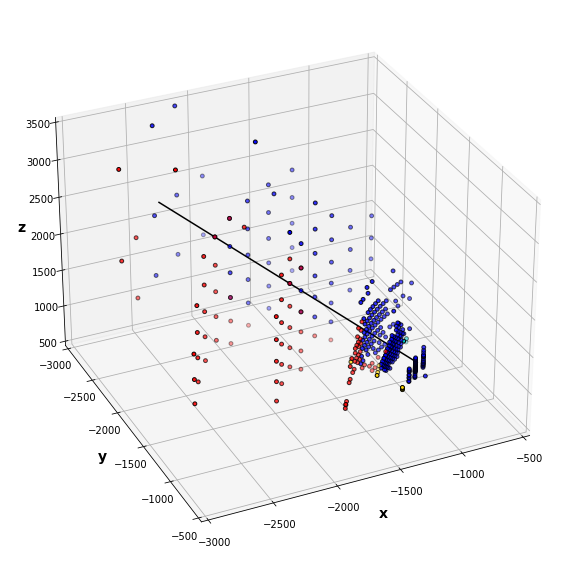

In [89]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=65)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
ax.plot(tracks_xyz[:,0], tracks_xyz[:,1], tracks_xyz[:,2], color='black')
ax.set_xlim(-500,-3000)
ax.set_ylim(-3000,-500)
ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev30_azim65_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

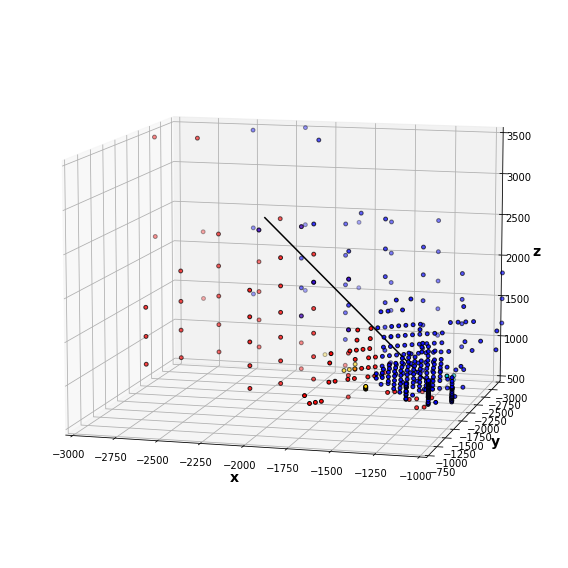

In [90]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=105)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
ax.plot(tracks_xyz[:,0], tracks_xyz[:,1], tracks_xyz[:,2], color='black')
ax.set_xlim(-1000,-3000)
ax.set_ylim(-3000,-750)
ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev10_azim105_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

# Ignore below, testing while other kernel is busy

In [100]:
def find_index_1D_dict(_values, _dict):
    ''' Use a for loop and a dictionary '''
    _shape = (len(_values), len(_unsorted))
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = np.tile(_unsorted, _shape[0]).reshape(_shape)
    _idx_vec = np.argmax(np.asarray(_values_2d == _unsorted_2d), axis=1)
    return _idx_vec

def find_index_1D_pythonic(_values, _unsorted):
    ''' pythonic implementation of stacking array '''
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = [_unsorted]*len(_values)
    _idx_vec = np.nonzero(_values_2d_T == _unsorted_2d, axis=0)
    return _idx_vec

def find_index_1D_tile(_values, _unsorted):
    ''' tile and reshape the array '''
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    print(_values_2D)
    _unsorted_2d = np.tile(_unsorted, (len(_values),1))
    print(_unsorted_2d)
    _idx_vec = np.nonzero(_values_2d_T == _unsorted_2d, axis=0)
    print(_idx_vec)
    return _idx_vec

def find_index_1D_vstack(_values, _unsorted):
    ''' use vstack a bunch '''
    _shape = (len(_values), len(_unsorted))
    # convert this to rows 
    _values_2D_T = np.atleast_2d(_values).transpose()
    _unsorted_2d = np.tile(_unsorted, _shape[0]).reshape(_shape)
    _idx_vec = np.argmax(np.asarray(_values_2d == _unsorted_2d), axis=1)
    return _idx_vec

In [96]:
a = np.arange(10)
np.random.shuffle(a)
vals = np.array([2,3])
print('Searching for: '+str(vals))
print('In: '+str(a))

Searching for: [2 3]
In: [1 7 4 8 5 2 3 6 9 0]


In [101]:
indices = find_index_1D_reps(vals, a)
print(indices)

[5 6]


In [109]:
arr = np.tile(np.arange(5), (5, 1)).astype(np.float32)
print(arr)
arr[:,2]*.1
print(arr)
arr[:,2] = arr[:,2]*.1
print(arr)

[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
[[0.  1.  0.2 3.  4. ]
 [0.  1.  0.2 3.  4. ]
 [0.  1.  0.2 3.  4. ]
 [0.  1.  0.2 3.  4. ]
 [0.  1.  0.2 3.  4. ]]
